# Introduction

In this project, I will use Python and its libraries to gather data related to the WeRateDogs Twitter account from three separate sources, assess its quality and tidiness, clean it, and ultimately create interesting and trustworthy analyses and visualizations

**Data Files**
1. **WeRateDogs Twitter Archive** - This file has been provided to us. It contains basic tweet data for the 2356 tweets that have ratings. It contains  each tweet's text, rating, dog name, and dog "stage". The rating is almost always have a denominator of 10. The numerators are almost always greater than 10. We know however that the ratings probably aren't all correct. Same goes for the dog names and probably dog stages. These will need to be assessed and cleaned for use in any analysis and visualization.

2. **Additional Data via the Twitter API** - Retweet count and favorite count are two of the notable column omissions from the WeRateDogs Twitter Archive. This additional data will need to be gathered from Twitter's API. Using the tweet IDs in the WeRateDogs Twitter archive, I will query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data will be written to its own line. I will then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. 

3. **Image Predictions File** - We have also been provided the tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and will have to be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

# Gathering Data

Per the above explanation, we are going to grather the data we need from 3 different sources: 1) an existing csv file, 2) programatically downloaded a tsv file, 3) queried Twitter's API using Tweepy

In [82]:
# Import all packages needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import tweepy 
import json
import time
import re

In [2]:
# Read the WeRateDogs Twitter Archive CSV file 

twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [4]:
# Download the Image Predictions File from Udacity's server

url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open('image-predictions.tsv', mode ='wb') as file:
    file.write(response.content)

# Read the image-predictions TSV file 
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t' )
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [5]:
# Query the Twitter API for each tweet's JSON data 

consumer_key = 'xx'
consumer_secret = 'xx'
access_token = 'xx'
access_secret = 'xx'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [6]:
# Add each tweet to a list
# Ref: https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id

df_list = []
error_list = []

start = time.time()

for tweet_id in twitter_archive['tweet_id']:
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended', wait_on_rate_limit = True,
                               wait_on_rate_limit_notify = True)._json 
        favorites = tweet['favorite_count'] # tweet's favorites
        retweets = tweet['retweet_count'] 
                
        df_list.append({'tweet_id': int(tweet_id), 'favorites': int(favorites), 'retweets': int(retweets)})
        
    except Exception as e:
        print(str(tweet_id)+ ":  " + str(e))
        error_list.append(tweet_id)
        

end = time.time()
print(end - start)

888202515573088257:  [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921:  [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937:  [{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745:  [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329:  [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744:  [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320:  [{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130:  [{'code': 144, 'message': 'No status found with that ID.'}]
851953902622658560:  [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705:  [{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984:  [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648:  [{'code': 144, 'message': 'No status found with that ID.'}]
837366284874571778:  [{'code

In [7]:
print("The lengh of the errors", len(error_list))

The lengh of the errors 25


There are 25 tweet IDs in the archive for which the corresponding tweets have been deleted - hence the 25 errors. 

In [8]:
# Create a dataframe with tweet ID, retweet count, and favorite count
df = pd.DataFrame(df_list, columns = ['tweet_id', 'favorites', 'retweets'])

# Save tweet df as a text file: 'tweet_json.txt'
df.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [9]:
tweet_data = pd.read_csv('tweet_json.txt', encoding = 'utf-8')
tweet_data

,tweet_id,favorites,retweets
0,892420643555336193,35355,7463
1,892177421306343426,30593,5538
2,891815181378084864,23022,3665
3,891689557279858688,38650,7638
4,891327558926688256,36918,8230
5,891087950875897856,18625,2756
6,890971913173991426,10818,1785
7,890729181411237888,59556,16690
8,890609185150312448,25621,3810
9,890240255349198849,29224,6475


# Assessing the Data

Now that we have gathered the data we need from the 3 separate sources, I will beging to assess each file for data quality and tidness issues, taking both a visual and programatic approach. 

### 1. WeRateDogs Twitter Archive ### 

In [10]:
pd.set_option('display.max_colwidth', -1)

In [11]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [12]:
twitter_archive.sample(30)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.816070e+17,47384430.0,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
1234,712717840512598017,NaN,NaN,2016-03-23 19:09:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Please don't send in any more polar bears. We only rate dogs. Thank you... 10/10 https://t.co/83RGhdIQz2,NaN,NaN,NaN,https://twitter.com/dog_rates/status/712717840512598017/photo/1,10,10,None,None,None,None,None
1293,708026248782585858,NaN,NaN,2016-03-10 20:26:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Everybody stop what you're doing and watch this video. Frank is stuck in a loop. 13/10 (Vid by @klbmatty) https://t.co/5AJs8TIV1U,NaN,NaN,NaN,https://twitter.com/dog_rates/status/708026248782585858/video/1,13,10,None,None,None,None,None
1396,699788877217865730,NaN,NaN,2016-02-17 02:54:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Nala. She's a Freckled High Bruschetta. Petable af. 12/10 https://t.co/5bjrIRqByp,NaN,NaN,NaN,https://twitter.com/dog_rates/status/699788877217865730/photo/1,12,10,Nala,None,None,None,None
1150,726224900189511680,NaN,NaN,2016-04-30 01:41:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I'm getting super heckin frustrated with you all sending in non canines like this ostrich. We only rate dogs... 9/10 https://t.co/Rgbni2Ns8z,NaN,NaN,NaN,https://twitter.com/dog_rates/status/726224900189511680/photo/1,9,10,None,None,None,None,None
283,838952994649550848,NaN,NaN,2017-03-07 03:22:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",SHE MISPLACED HER HOOMAN 13/10 MISTAKES HAPPEN https://t.co/ngAxYLVYHP,NaN,NaN,NaN,https://twitter.com/ktla/status/838948714227998720,13,10,None,None,None,None,None
1986,672884426393653248,NaN,NaN,2015-12-04 21:05:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Marvelous dog here. Rad ears. Not very soft. Large tumor on nose. Has a pet rock. Good w kids. 6/10 overall neat pup https://t.co/g5YkRqP0dg,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672884426393653248/photo/1,6,10,None,None,None,None,None
1576,687460506001633280,NaN,NaN,2016-01-14 02:25:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Kramer. He's a Picasso Tortellini. Tie couldn't be more accurate. Confident af. Runs his own business. 10/10 https://t.co/jIcVW0xxmH,NaN,NaN,NaN,https://twitter.com/dog_rates/status/687460506001633280/photo/1,10,10,Kramer,None,None,None,None
1145,727175381690781696,NaN,NaN,2016-05-02 16:38:15 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Karll. He just wants to go kayaking. 10/10 please someone take Karll kayaking already https://t.co/vXLkvyNQHp,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/727175381690781696/photo/1,https://twitter.com/dog_rates/status/727175381690781696/photo/1",10,10,Karll,None,None,None,None
1383,700847567345688576,NaN,NaN,2016-02-20 01:00:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Crouton. He's a Galapagos Boonwiddle. Has a legendary tongue (most Boonwiddles do). Excellent stuff 10/10 https://t.co/110Eeg7KW3,NaN,NaN,NaN,https://twitter.com/dog_rates/status/700847567345688576/photo/1,10,10,Crouton,None,None,None,None


In [13]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [14]:
twitter_archive.isnull().sum()

tweet_id                      0   
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                     0   
source                        0   
text                          0   
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                 59  
rating_numerator              0   
rating_denominator            0   
name                          0   
doggo                         0   
floofer                       0   
pupper                        0   
puppo                         0   
dtype: int64

In [15]:
twitter_archive['tweet_id'].duplicated().any()

False

In [16]:
twitter_archive['doggo'].value_counts()

None     2259
doggo    97  
Name: doggo, dtype: int64

In [17]:
twitter_archive['floofer'].value_counts()

None       2346
floofer    10  
Name: floofer, dtype: int64

In [18]:
twitter_archive['pupper'].value_counts()

None      2099
pupper    257 
Name: pupper, dtype: int64

In [19]:
twitter_archive['puppo'].value_counts()

None     2326
puppo    30  
Name: puppo, dtype: int64

In [20]:
twitter_archive[(twitter_archive['doggo']== 'None') & (twitter_archive['floofer']== 'None') & (twitter_archive['pupper']== 'None') & (twitter_archive['puppo']== 'None')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
10,8900066081

In [21]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [22]:
twitter_archive[twitter_archive['rating_denominator'] != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,None,None,None,None
1202,716439118184

In [23]:
len(twitter_archive[twitter_archive['rating_denominator'] != 10])

23

In [24]:
twitter_archive[twitter_archive['rating_numerator'] < 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None
229,848212111729840128,NaN,NaN,2017-04-01 16:35:01 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Jerry. He's doing a distinguished tongue slip. Slightly patronizing tbh. You think you're better than us, Jerry? 6/10 hold me back https://t.co/DkOBbwulw1",NaN,NaN,NaN,https://twitter.com/dog_rates/status/848212111729840128/photo/1,6,10,Jerry,None,None,None,None
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1",0,10,None,None,None,None,None
387,826598799820865537,8.265984e+17,4.196984e+09,2017-02-01 01:11:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","I was going to do 007/10, but the joke wasn't worth the &lt;10 rating",NaN,NaN,NaN,NaN,7,10,None,None,None,None,None
462,817502432452313088,NaN,NaN,2017-01-06 22:45:43 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Herschel. He's slightly bigger than ur average pupper. Looks lonely. Could probably ride 7/10 would totally pet https:/…,6.924173e+17,4.196984e+09,2016-01-27 18:42:06 +0000,https://twitter.com/dog_rates/status/692417313023332352/photo/1,7,10,Herschel,None,None,pupper,None
485,814578408554463233,NaN,NaN,2016-12-29 21:06:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur stole Beau's bed from him. Wilbur now has so much room for activities. 9/10 for both pups https:/…,6.981954e+17,4.196984e+09,2016-02-12 17:22:12 +0000,https://twitter.com/dog_rates/status/698195409219559425/photo/1,9,10,Beau,None,None,None,None
599,798682547630837760,NaN,NaN,2016-11-16 00:22:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Here we see a rare pouched pupper. Ample storage space. Looks alert. Jumps at random. Kicked open that door. 8/10 https://t.…,6.769365e+17,4.196984e+09,2015-12-16 01:27:03 +0000,https://twitter.com/dog_rates/status/676936541936185344/photo/1,8,10,None,None,None,pupper,None
605,798576900688019456,NaN,NaN,2016-11-15 17:22:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…,6.661041e+17,4.196984e+09,2015-11-16 04:02:55 +0000,https://twitter.com/dog_rates/status/666104133288665088/photo/1,1,10,None,None,None,None,None
730,781661882474196992,NaN,NaN,2016-09-30 01:08:10 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC,NaN,NaN,NaN,https://twitter.com/dog_rates/status/781661882474196992/photo/1,5,10,None,None,None,None,None


In [25]:
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7       55 
14      54 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

In [26]:
twitter_archive[(twitter_archive['rating_numerator']== 1776)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776,10,Atticus,None,None,None,None


In [27]:
twitter_archive[twitter_archive['name'].apply(len) <= 2]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004380872706/video/1,14,10,a,None,None,pupper,None
393,825876512159186944,NaN,NaN,2017-01-30 01:21:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Mo. No one will push him around in the grocery cart. He's quite pupset about it. 11/10 I volunteer https://t.co/feNwTq12S5,NaN,NaN,NaN,https://twitter.com/dog_rates/status/825876512159186944/photo/1,11,10,Mo,None,None,None,None
446,819015337530290176,NaN,NaN,2017-01-11 02:57:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1,8.190048e+17,4.196984e+09,2017-01-11 02:15:36 +0000,"https://twitter.com/dog_rates/status/819004803107983360/photo/1,https://twitter.com/dog_rates/status/819004803107983360/photo/1,https://twitter.com/dog_rates/status/819004803107983360/photo/1,https://twitter.com/dog_rates/status/819004803107983360/photo/1,https://twitter.com/dog_rates/status/819004803107983360/photo/1,https://twitter.com/dog_rates/status/819004803107983360/photo/1,https://twitter.com/dog_rates/status/819004803107983360/photo/1,https://twitter.com/dog_rates/status/819004803107983360/photo/1",14,10,Bo,doggo,None,None,None
449,819004803107983360,NaN,NaN,2017-01-11 02:15:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/819004803107983360/photo/1,https://twitter.com/dog_rates/status/819004803107983360/photo/1,https://twitter.com/dog_rates/status/819004803107983360/photo/1,https://twitter.com/dog_rates/status/819004803107983360/photo/1",14,10,Bo,doggo,None,None,None
553,804026241225523202,NaN,NaN,2016-11-30 18:16:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bo. He's going to make me cry. 13/10 please get off the bus for him Carly https://t.co/U7FvBZo6Bq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/804026241225523202/photo/1,https://twitter.com/dog_rates/status/804026241225523202/photo/1,https://twitter.com/dog_rates/status/804026241225523202/photo/1",13,10,Bo,None,None,None,None
583,800188575492947969,NaN,NaN,2016-11-20 04:06:37 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Bo. He's a Benedoop Cumbersnatch. Seems frustrated with own feet. Portable as hell. 11/10 very solid pupper https://…,6.816941e+17,4.196984e+09,2015-12-29 04:31:49 +0000,https://twitter.com/dog_rates/status/681694085539872773/photo/1,11,10,Bo,None,None,pupper,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1",13,10,a,None,None,None,None
679,789137962068021249,NaN,NaN,2016-10-20 16:15:26 +0000,"<a href=""ht

In [28]:
twitter_archive[twitter_archive['name'].apply(len) <= 2]['name'].value_counts()

a     55
Bo    9 
an    7 
O     1 
my    1 
Mo    1 
by    1 
JD    1 
Ed    1 
Al    1 
Jo    1 
Name: name, dtype: int64

In [29]:
len(twitter_archive[twitter_archive['name'] == 'None'])

745

In [30]:
twitter_archive[(twitter_archive['doggo']== 'doggo') & (twitter_archive['floofer']== 'floofer')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",11,10,None,doggo,floofer,None,None


Dog should be classified as a floofer and not a doggo

In [31]:
twitter_archive[(twitter_archive['doggo']== 'doggo') & (twitter_archive['pupper']== 'pupper')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686764523521/video/1,13,10,Dido,doggo,None,pupper,None
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460588765185/photo/1,12,10,None,doggo,None,pupper,None
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048156610565/photo/1,11,10,None,doggo,None,pupper,None
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/status/801115127852503040/photo/1",12,10,Bones,doggo,None,pupper,None
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/785639753186217984/photo/1,https://twitter.com/dog_rates/status/785639753186217984/photo/1",10,10,Pinot,doggo,None,pupper,None
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>","Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,"https://twitter.com/dog_rates/status/733109485275860992/photo/1,https://twitter.com/dog_rates/status/733109485275860992/photo/1",12,10,None,doggo,None,pupper,None
822,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,"https://twitter.com/dog_rates/status/741067306818797568/photo/1,https://twitter.com/dog_rates/status/741067306818797568/photo/1",12,10,just,doggo,None,pupper,None
889,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/759793422261743616/photo/1,https://twitter.com/dog_rates/status/759793422261743616/photo/1",12,10,Maggie,doggo,Non

In [32]:
len(twitter_archive[(twitter_archive['doggo']== 'doggo') & (twitter_archive['pupper']== 'pupper')])

12

Most tweets are referring to two separate dogs doggo and pupper. 

In [33]:
twitter_archive[(twitter_archive['doggo']== 'doggo') & (twitter_archive['puppo']== 'puppo')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453814013952/photo/1,13,10,None,doggo,None,None,puppo


Puppo misclassified as a doggo

In [34]:
twitter_archive[(twitter_archive['floofer']== 'floofer') & (twitter_archive['pupper']== 'pupper')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [35]:
twitter_archive[(twitter_archive['floofer']== 'floofer') & (twitter_archive['puppo']== 'puppo')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [36]:
twitter_archive[(twitter_archive['pupper']== 'pupper') & (twitter_archive['puppo']== 'puppo')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


**WeRateDogs Twitter Archive *Quality* Observations**
1. There are retweets included in the dataset (181) as denoted in the retweeted_status_id column (text for each retweet also starts with "RT @")
2. 1,976 tweets have no dog stage identified (i.e. all 4 stages == None)
3. There are erroneous numerators and denominators (e.g. 7/11, 9/11) and at least 1 float numerator not properly captured
4. There are 65 invalid names included in the dataset (a, an and less than 3 characters).
5. There are 745 tweets with 'None' listed as the name (i.e. no dog name identified)
6. There are 14 tweets with more than 1 dog stage classification 
7. "retweeted_status_timestamp", "timestamp" should be datetime instead of object (string)
8. ID columns are of integer or float datatype. We may want to change the datatype for these columns to string as we don't want any operations on them

**WeRateDogs Twitter Archive *Tidiness* Observations**
1. Dog stage is in 4 separate columns (doggo, floofer, pupper, puppo)
2. Missing column for the fraction of rating_numerator and rating_denominator
3. Columns not required for analysis can be deleted


### 2. Image Prediction ### 

In [37]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [38]:
image_predictions.sample(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
465,675006312288268288,https://pbs.twimg.com/media/CV4aqCwWsAIi3OP.jpg,1,boxer,0.654697,True,space_heater,0.043389,False,beagle,0.042848,True
1665,812503143955202048,https://pbs.twimg.com/media/C0aXTLqXEAADxBi.jpg,2,loupe,0.546856,False,web_site,0.345298,False,bubble,0.010528,False
606,679877062409191424,https://pbs.twimg.com/media/CW9olDsUsAA0XSf.jpg,1,hog,0.809466,False,hay,0.060178,False,lumbermill,0.016483,False
255,670755717859713024,https://pbs.twimg.com/media/CU8AwZ_UsAA-Lbu.jpg,1,keeshond,0.994065,True,Norwegian_elkhound,0.001827,True,cairn,0.001821,True
1623,803638050916102144,https://pbs.twimg.com/ext_tw_video_thumb/803638023904559104/pu/img/vxm0Htm5iIV7EOAQ.jpg,1,Labrador_retriever,0.372776,True,golden_retriever,0.343666,True,Great_Pyrenees,0.067242,True
559,677700003327029250,https://pbs.twimg.com/media/CWesj06W4AAIKl8.jpg,1,Siberian_husky,0.120849,True,junco,0.079206,False,malamute,0.063088,True
1450,776218204058357768,https://pbs.twimg.com/media/CsWuVEdWcAAqbe9.jpg,1,Samoyed,0.940326,True,Pomeranian,0.055527,True,keeshond,0.002226,True
1562,793500921481273345,https://pbs.twimg.com/media/CwMU34YWIAAz1nU.jpg,2,golden_retriever,0.326122,True,Labrador_retriever,0.219904,True,Chesapeake_Bay_retriever,0.163366,True
1233,746131877086527488,https://pbs.twimg.com/media/ClrK-rGWAAENcAa.jpg,1,chow,0.575637,True,Pomeranian,0.195950,True,Norwich_terrier,0.141224,True
325,671882082306625538,https://pbs.twimg.com/media/CVMBL_LWUAAsvrL.jpg,1,ski_mask,0.968325,False,mask,0.021863,False,abaya,0.005479,False


In [39]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [40]:
image_predictions['tweet_id'].nunique()

2075

In [41]:
image_predictions['jpg_url'].nunique()

2009

**Image Prediction *Quality* Observations**
1. There are only 2075 image predictions (vs. the 2356 tweets in the archive file). Perhaps due to Aug 1 2017 date cutoff?
2. There are 66 fewer unique JPG URLs than there are tweet IDs - likely due to retweets
3. tweet_id is of int datatype; should be type object as no calculation is needed
4. Dog breed in p1, p2, and p3 are inconsitently lower or uppercase


**Image Prediction *Tidiness* Observations**
1. The jpg_url, breed predictions and prediction confidence should be joined to twitter_archive DataFrame
2. The true breed predictions and prediction confidence scores should be consolidated into 1 column

### 3. Twitter API Retweet & Favourite Counts ### 

In [42]:
tweet_data.head()

,tweet_id,favorites,retweets
0,892420643555336193,35355,7463
1,892177421306343426,30593,5538
2,891815181378084864,23022,3665
3,891689557279858688,38650,7638
4,891327558926688256,36918,8230


In [43]:
tweet_data.sample(20)

,tweet_id,favorites,retweets
268,839549326359670784,26816,7499
2029,671390180817915904,1353,691
1374,699775878809702401,1905,582
2082,670465786746662913,913,505
1379,699413908797464576,2029,607
2297,666430724426358785,290,173
1059,738537504001953792,4947,1479
1902,674051556661161984,1374,460
1489,691096613310316544,2882,854
661,789137962068021249,9677,2767


In [44]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id     2331 non-null int64
favorites    2331 non-null int64
retweets     2331 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


**Twitter API Retweet & Favourite Counts *Quality* Observations**
1. tweet_id is of int datatype; should be type object as no calculation is needed

**Twitter API Retweet & Favourite Counts *Tidiness* Observations**
1. favorite count and retweet count columns should be joined to twitter_archive DataFrame

# Cleaning the Data

Now that we have identified the top quality and tidiness issues with each of the datasets, we are going to clean them. We will do this by defining, coding, and testing the cleaning action required for each item.

In [45]:
# We will first create copies of the dataframes

tweet_data_clean = tweet_data.copy()
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean= image_predictions.copy()

**Define:**

Merge the 3 dataframes: tweet_data_clean, twitter_archive_clean, and image_predictions_clean. This may also address some of the quality issues identified in the assess stage (e.g. null values, more tweets in tweet archives than in image predictions, etc.)

**Code:**

In [46]:
# Merge twitter_archive_clean and image_predictions_clean dataframes

twitter_archive_clean = pd.merge(left=twitter_archive_clean, right=image_predictions_clean, left_on='tweet_id', right_on='tweet_id', how='inner')

In [47]:
# Merge the new twitter_archive_clean and tweet_data_clean dataframes

twitter_archive_clean = twitter_archive_clean.merge(tweet_data_clean, on='tweet_id', how='inner')

**Test:**

In [48]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorites,retweets
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,35355,7463
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,30593,5538
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,23022,3665
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,38650,7638
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,36918,8230


In [49]:
# Check to see all columns have merged

twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 30 columns):
tweet_id                      2059 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2059 non-null object
source                        2059 non-null object
text                          2059 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2059 non-null object
rating_numerator              2059 non-null int64
rating_denominator            2059 non-null int64
name                          2059 non-null object
doggo                         2059 non-null object
floofer                       2059 non-null object
pupper                        2059 non-null object
puppo                         2059 non-null object
jpg_url                       2059 

**Define:**

Eliminate retweets from dataset by filltering on column retweeted_status_id for null values (i.e. without retweet status IDs). This will also address the quality issue of having 66 fewer unique JPG URLs than unique tweet IDs - likely due to retweets.

**Code:**

In [50]:
# Filter on the retweeted_status_user_id for null values

twitter_archive_clean = twitter_archive_clean[pd.isnull(twitter_archive_clean['retweeted_status_user_id'])]

**Test:**

In [51]:
# Check to see if any non-null values remain in the retweeted_status_user_id column

twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2058
Data columns (total 30 columns):
tweet_id                      1987 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1987 non-null object
source                        1987 non-null object
text                          1987 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1987 non-null object
rating_numerator              1987 non-null int64
rating_denominator            1987 non-null int64
name                          1987 non-null object
doggo                         1987 non-null object
floofer                       1987 non-null object
pupper                        1987 non-null object
puppo                         1987 non-null object
jpg_url                       1987 non

In [52]:
# Check to see if the number of unique JPG URLs match the number of unqique tweet IDs

twitter_archive_clean['jpg_url'].nunique()

1987

**Define:**

Consolidate the 4 separate dog stage columns into one column called "dog_stage"

In [53]:
# Delete 'None' values in the doggo, pupper, puppo, and floofer columns

twitter_archive_clean.doggo.replace('None', '', inplace = True)
twitter_archive_clean.floofer.replace('None', '', inplace = True)
twitter_archive_clean.pupper.replace('None', '', inplace = True)
twitter_archive_clean.puppo.replace('None', '', inplace = True)

In [54]:
twitter_archive_clean.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,,,,,1682
1,,,,puppo,22
2,,,pupper,,203
3,,floofer,,,7
4,doggo,,,,62
5,doggo,,,puppo,1
6,doggo,,pupper,,9
7,doggo,floofer,,,1


In [55]:
# Consolidate the 4 columns into 1

twitter_archive_clean['dog_stage'] = twitter_archive_clean.doggo + twitter_archive_clean.floofer + twitter_archive_clean.pupper + twitter_archive_clean.puppo

In [56]:
# Clean up records with more two dog stages (i.e. doggo + puppo, doggo + pupper, and doggo + floofer)

twitter_archive_clean.dog_stage.replace('doggopuppo', 'doggo, puppo', inplace = True)
twitter_archive_clean.dog_stage.replace('doggopupper', 'doggo, pupper', inplace = True)
twitter_archive_clean.dog_stage.replace('doggofloofer', 'doggo, floofer', inplace = True)

**Test:**

In [57]:
# test to see if the dog stages were consolidated appropriately

twitter_archive_clean['dog_stage'].value_counts()

                  1682
pupper            203 
doggo             62  
puppo             22  
doggo, pupper     9   
floofer           7   
doggo, floofer    1   
doggo, puppo      1   
Name: dog_stage, dtype: int64

In [58]:
twitter_archive_clean.loc[:, 'doggo':'dog_stage']

,doggo,floofer,pupper,puppo,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorites,retweets,dog_stage
0,,,,,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,35355,7463,
1,,,,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,30593,5538,
2,,,,,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,23022,3665,
3,,,,,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,38650,7638,
4,,,,,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,36918,8230,
5,,,,,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,18625,2756,
6,,,,,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False,10818,1785,
7,,,,,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True,59556,16690,
8,,,,,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True,25621,3810,
9,doggo,,,,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,29224,6475,doggo


**Define:**

For tweets without a dog stage defined, attempt to extract dog stage from the tweet text and add to dog_stage column

In [59]:
twitter_archive_clean[twitter_archive_clean['text'].str.contains('doggo')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorites,retweets,dog_stage
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255349198849/photo/1,...,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,29224,6475,doggo
38,884162670584377345,NaN,NaN,2017-07-09 21:29:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at all times. 12/10 for dangerously dapper doggo https://t.co/YSI00BzTBZ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884162670584377345/photo/1,...,True,malinois,0.199396,True,Norwegian_elkhound,0.049148,True,18741,2647,doggo
83,872967104147763200,NaN,NaN,2017-06-09 00:02:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a very large dog. He has a date later. Politely asked this water person to check if his breath is bad. 12/10 good to go doggo https://t.co/EMYIdoblMR,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/872967104147763200/photo/1,https://twitter.com/dog_rates/status/872967104147763200/photo/1",...,True,Chesapeake_Bay_retriever,0.174145,True,German_short-haired_pointer,0.092861,True,25148,4833,doggo
90,871515927908634625,NaN,NaN,2017-06-04 23:56:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Napolean. He's a Raggedy East Nicaraguan Zoom Zoom. Runs on one leg. Built for deception. No eyes. Good with kids. 12/10 great doggo https://t.co/PR7B7w1rUw,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/871515927908634625/photo/1,https://twitter.com/dog_rates/status/871515927908634625/photo/1",...,True,briard,0.020041,True,swab,0.003228,False,18683,3118,doggo
99,869596645499047938,NaN,NaN,2017-05-30 16:49:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Scout. He just graduated. Officially a doggo now. Have fun with taxes and losing sight of your ambitions. 12/10 would throw cap for https://t.co/DsA2hwXAJo,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/869596645499047938/photo/1,https://twitter.com/dog_rates/status/869596645499047938/photo/1",...,True,toy_terrier,0.008054,True,muzzle,0.006296,False,14822,2803,doggo
140,858843525470990336,NaN,NaN,2017-05-01 00:40:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I have stumbled puppon a doggo painting party. They're looking to be the next Pupcasso or Puppollock. All 13/10 would put it on the fridge https://t.co/cUeDMlHJbq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/858843525470990336/photo/1,...,True,Labrador_retriever,0.286059,True,bloodhound,0.026917,True,14723,3212,doggo
151,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453814013952/photo/1,...,True,Labrador_retriever,0.115138,True,groenendael,0.096100,True,43570,16914,"doggo, puppo"
157,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT

As an example, there are 75 tweets that contain the dog stage "doggo" in the tweet text. Some of these tweets do not have a dog stage defined in the dog_stage column.

**Code:**

In [60]:
# Define a function that searches the tweet text for tweets without a dog stage defined (i.e. len == 0), and returns the dog stage (if found)

def function(x): 
    if len(x.dog_stage)==0:
        if 'doggo' in x.text:
            return 'doggo'
        elif 'puppo' in x.text:
            return 'puppo'
        elif 'pupper' in x.text:
            return 'pupper'
        elif 'floofer' in x.text:
            return 'floofer'
        else:
            return np.NaN
    else:
        return x.dog_stage

In [61]:
# Apply function to the dog_stage column

twitter_archive_clean['dog_stage'] = twitter_archive_clean.apply(function, axis=1)

**Test:**

In [62]:
twitter_archive_clean['dog_stage'].value_counts()

pupper            226
doggo             68 
puppo             26 
doggo, pupper     9  
floofer           7  
doggo, floofer    1  
doggo, puppo      1  
Name: dog_stage, dtype: int64

In [63]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2058
Data columns (total 31 columns):
tweet_id                      1987 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1987 non-null object
source                        1987 non-null object
text                          1987 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1987 non-null object
rating_numerator              1987 non-null int64
rating_denominator            1987 non-null int64
name                          1987 non-null object
doggo                         1987 non-null object
floofer                       1987 non-null object
pupper                        1987 non-null object
puppo                         1987 non-null object
jpg_url                       1987 non

Looks like we were able to extract some more dog stages from the body of the tweet. Although, there are still quite a few tweets withouth a dog stage defined. 

**Define:**

Drop columns not necessary for our analysis (i.e. doggo, puppo, pupper, floofer, in_reply_to_status_id, in_reply_to_user_id, source, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)   

In [64]:
# Drop columns

twitter_archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id',
                                                   'retweeted_status_timestamp', 'in_reply_to_status_id',
                                                   'in_reply_to_user_id', 'source', 'doggo', 'puppo', 'pupper', 
                                                   'floofer'], axis = 1, inplace = True)

**Test:**

In [65]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2058
Data columns (total 21 columns):
tweet_id              1987 non-null int64
timestamp             1987 non-null object
text                  1987 non-null object
expanded_urls         1987 non-null object
rating_numerator      1987 non-null int64
rating_denominator    1987 non-null int64
name                  1987 non-null object
jpg_url               1987 non-null object
img_num               1987 non-null int64
p1                    1987 non-null object
p1_conf               1987 non-null float64
p1_dog                1987 non-null bool
p2                    1987 non-null object
p2_conf               1987 non-null float64
p2_dog                1987 non-null bool
p3                    1987 non-null object
p3_conf               1987 non-null float64
p3_dog                1987 non-null bool
favorites             1987 non-null int64
retweets              1987 non-null int64
dog_stage             338 non-null object


**Define:**

Consolidate and tidy up the image predictions into the breed_predictions column, based on whether or not the 1st, 2nd and 3rd predictions are actual dog breeds.

**Code:**

In [66]:
# Append the first True predection to the list 'perdictions' and the level appended to list 'confidence_level', otherwise, append NaN.

predictions = []
confidence_level = []

def prediction_func(dataframe):
    if dataframe['p1_dog'] == True:
        predictions.append(dataframe['p1'])
        confidence_level.append(dataframe['p1_conf'])
    elif dataframe['p2_dog'] == True:
        predictions.append(dataframe['p2'])
        confidence_level.append(dataframe['p2_conf'])
    elif dataframe['p3_dog'] == True:
        predictions.append(dataframe['p3'])
        confidence_level.append(dataframe['p3_conf'])
    else:
        predictions.append('NaN')
        confidence_level.append(0)

twitter_archive_clean.apply(prediction_func, axis=1)
twitter_archive_clean['breed_prediction'] = predictions
twitter_archive_clean['prediction_confidence'] = confidence_level

In [67]:
# Drop old prediction columns

twitter_archive_clean = twitter_archive_clean.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
                                                    'p2_dog', 'p3', 'p3_conf', 'p3_dog'], 1)

**Test:**

In [68]:
twitter_archive_clean.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,favorites,retweets,dog_stage,breed_prediction,prediction_confidence
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,35355,7463,NaN,NaN,0.000000
1,892177421306343426,2017-08-01 00:17:27 +0000,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,30593,5538,NaN,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,23022,3665,NaN,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,38650,7638,NaN,Labrador_retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24 +0000,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,36918,8230,NaN,basset,0.555712


**Define:**

Make all dog breed predictions uppercase

**Code:**

In [69]:
twitter_archive_clean['breed_prediction'] = twitter_archive_clean['breed_prediction'].str.capitalize()

**Test:**

In [70]:
twitter_archive_clean.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,favorites,retweets,dog_stage,breed_prediction,prediction_confidence
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,35355,7463,NaN,Nan,0.000000
1,892177421306343426,2017-08-01 00:17:27 +0000,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,30593,5538,NaN,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,23022,3665,NaN,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,38650,7638,NaN,Labrador_retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24 +0000,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,36918,8230,NaN,Basset,0.555712


**Define:**

Change the tweet_id datatype to string

**Code:** 

In [71]:
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)

**Test:**

In [72]:
twitter_archive_clean['tweet_id'].dtypes

dtype('O')

**Define:**

Convert timestamp to datetime format

**Code:**

In [73]:
#Remove the time zone from the 'timestamp' column

twitter_archive_clean['timestamp'] = twitter_archive_clean['timestamp'].str.slice(start=0, stop=-6)

In [74]:
# Change the 'timestamp' column to a datetime object

twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'], format = "%Y-%m-%d %H:%M:%S")

**Test:**

In [75]:
twitter_archive_clean.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,favorites,retweets,dog_stage,breed_prediction,prediction_confidence
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,35355,7463,NaN,Nan,0.000000
1,892177421306343426,2017-08-01 00:17:27,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,30593,5538,NaN,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,23022,3665,NaN,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,38650,7638,NaN,Labrador_retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,36918,8230,NaN,Basset,0.555712


**Define:**

Extract the correct rating from the tweet text for tweets with multiple ratings.

**Code:**

In [86]:
# View all occurences where there are more than one #/# in 'text' column

twitter_archive_clean[twitter_archive_clean.text.str.contains( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")].text

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


605     "Yep... just as I suspected. You're not flossing." 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ                                
812     This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ                   
863     After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ       
954     Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a                                                                                   
988     This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq                              
1004    Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp https://t.co/Akzl5ynMmE   
1126    This is Socks. That water pup w the super legs just spla

In [87]:
# Identify and save the text where the rating numerator and denominators were incorrectly extracted

ratings_text = ['After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ', 
 'Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a', 
 'This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq', 
 'This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5',
 'This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv']

In [88]:
# Loop through the "ratings_text" list and extract the second occurence of #/ to save as the rating numerator. 

# Since all occurences of the actual ratings in the "ratings_text" have a denominator of 10, we will set that value for each 
#entry instead of extracting it.

for i in ratings_text:
    x = twitter_archive_clean.text == i
    column_1 = 'rating_numerator'
    column_2 = 'rating_denominator'
    twitter_archive_clean.loc[x, column_1] = re.findall(r"\d+\.?\d*\/\d+\.?\d*\D+(\d+\.?\d*)\/\d+\.?\d*", i)
    twitter_archive_clean.loc[x, column_2] = 10

**Test:**

In [89]:
twitter_archive_clean[twitter_archive_clean.text.isin(ratings_text)]

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,favorites,retweets,dog_stage,breed_prediction,prediction_confidence
863,740373189193256964,2016-06-08 02:41:38,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",14,10,None,https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg,34093,12904,NaN,Golden_retriever,0.807644
954,722974582966214656,2016-04-21 02:25:47,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,13,10,None,https://pbs.twimg.com/media/CgiFjIpWgAA4wVp.jpg,3969,1515,NaN,Great_dane,0.246762
988,716439118184652801,2016-04-03 01:36:11,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,11,10,Bluebert,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg,2310,202,NaN,Siberian_husky,0.396495
1392,682962037429899265,2016-01-01 16:30:13,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,https://twitter.com/dog_rates/status/682962037429899265/photo/1,10,10,Darrel,https://pbs.twimg.com/media/CXpeVzQW8AApKYb.jpg,35669,15861,NaN,Chihuahua,0.155207
2038,666287406224695296,2015-11-16 16:11:11,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,9,10,an,https://pbs.twimg.com/media/CT8g3BpUEAAuFjg.jpg,131,57,NaN,Maltese_dog,0.857531


**Define:** 

Clean decimal values in rating numerators.

**Code:**

In [90]:
# View tweets with decimals in their rating in the 'text' column

twitter_archive_clean[twitter_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,favorites,retweets,dog_stage,breed_prediction,prediction_confidence
40,883482846933004288,2017-07-08 00:28:19,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,42050,8737,NaN,Golden_retriever,0.943082
548,786709082849828864,2016-10-13 23:23:56,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,18143,6065,NaN,Pomeranian,0.467321
603,778027034220126208,2016-09-20 00:24:34,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,6488,1582,pupper,Clumber,0.946718
1438,680494726643068929,2015-12-25 21:06:00,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,1672,469,pupper,Kuvasz,0.438627


In [100]:
# Change datatype of rating_numerator and denominator to float

twitter_archive_clean['rating_numerator'] = twitter_archive_clean['rating_numerator'].astype('float')
twitter_archive_clean['rating_denominator'] = twitter_archive_clean['rating_denominator'].astype('float')

In [101]:
# Create a list with tweet IDs of the tweets with a decimal rating

id_list = twitter_archive_clean['tweet_id'][twitter_archive_clean.text.str.contains( r'(\d+\.\d+)/(\d+)')].tolist()
id_list

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


['883482846933004288',
 '786709082849828864',
 '778027034220126208',
 '680494726643068929']

In [102]:
# Create a list with the decimal numerrators  ratings of the tweets with a decimal rating

rating_list = twitter_archive_clean['text'].str.extract( r'(\d+\.\d+)/(\d+)')[0].dropna().tolist()
rating_list

['13.5', '9.75', '11.27', '11.26']

In [103]:
# Create a dictionary of the tweet ID and decimal ratings using the two lists just created

rating_dict = dict(zip(id_list, rating_list))
rating_dict

{'883482846933004288': '13.5',
 '786709082849828864': '9.75',
 '778027034220126208': '11.27',
 '680494726643068929': '11.26'}

In [104]:
# Use the created dictionary to change the wrong rating numerators with the correct value 

twitter_archive_clean.loc[twitter_archive_clean['tweet_id'].isin(rating_dict.keys()), 'rating_numerator'] = twitter_archive_clean['tweet_id'].map(my_dict)

In [106]:
twitter_archive_clean['rating_numerator'].dtypes

dtype('O')

In [109]:
twitter_archive_clean['rating_numerator'] = twitter_archive_clean['rating_numerator'].astype('float')

In [108]:
twitter_archive_clean['rating_numerator'].dtypes

dtype('float64')

**Test:**

In [110]:
twitter_archive_clean[twitter_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,favorites,retweets,dog_stage,breed_prediction,prediction_confidence
40,883482846933004288,2017-07-08 00:28:19,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",13.50,10.0,Bella,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,42050,8737,NaN,Golden_retriever,0.943082
548,786709082849828864,2016-10-13 23:23:56,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,9.75,10.0,Logan,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,18143,6065,NaN,Pomeranian,0.467321
603,778027034220126208,2016-09-20 00:24:34,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,https://twitter.com/dog_rates/status/778027034220126208/photo/1,11.27,10.0,Sophie,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,6488,1582,pupper,Clumber,0.946718
1438,680494726643068929,2015-12-25 21:06:00,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,11.26,10.0,None,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,1672,469,pupper,Kuvasz,0.438627


In [111]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2058
Data columns (total 13 columns):
tweet_id                 1987 non-null object
timestamp                1987 non-null datetime64[ns]
text                     1987 non-null object
expanded_urls            1987 non-null object
rating_numerator         1987 non-null float64
rating_denominator       1987 non-null float64
name                     1987 non-null object
jpg_url                  1987 non-null object
favorites                1987 non-null int64
retweets                 1987 non-null int64
dog_stage                338 non-null object
breed_prediction         1987 non-null object
prediction_confidence    1987 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory usage: 297.3+ KB


**Define:**

Create an overall rating column based on the rating numerator and demonimator

**Code:**

In [122]:
twitter_archive_clean['overall_rating'] = twitter_archive_clean['rating_numerator'] / twitter_archive_clean['rating_denominator']

**Test:**

In [123]:
twitter_archive_clean.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,favorites,retweets,dog_stage,breed_prediction,prediction_confidence,overall_rating
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,35355,7463,NaN,Nan,0.000000,1.3
1,892177421306343426,2017-08-01 00:17:27,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,30593,5538,NaN,Chihuahua,0.323581,1.3
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,23022,3665,NaN,Chihuahua,0.716012,1.2
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,38650,7638,NaN,Labrador_retriever,0.168086,1.3
4,891327558926688256,2017-07-29 16:00:24,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,36918,8230,NaN,Basset,0.555712,1.2


In [124]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2058
Data columns (total 14 columns):
tweet_id                 1987 non-null object
timestamp                1987 non-null datetime64[ns]
text                     1987 non-null object
expanded_urls            1987 non-null object
rating_numerator         1987 non-null float64
rating_denominator       1987 non-null float64
name                     1987 non-null object
jpg_url                  1987 non-null object
favorites                1987 non-null int64
retweets                 1987 non-null int64
dog_stage                338 non-null object
breed_prediction         1987 non-null object
prediction_confidence    1987 non-null float64
overall_rating           1987 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(2), object(7)
memory usage: 312.9+ KB


In [125]:
# Save the cleaned up datafram to csv

twitter_archive_clean.to_csv('twitter_archive_master.csv', encoding = 'utf-8', index=False)

In [126]:
# Test to make sure file saved properly

twitter_archive_master = pd.read_csv('twitter_archive_master.csv')
twitter_archive_master.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,favorites,retweets,dog_stage,breed_prediction,prediction_confidence,overall_rating
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,35355,7463,NaN,Nan,0.000000,1.3
1,892177421306343426,2017-08-01 00:17:27,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,30593,5538,NaN,Chihuahua,0.323581,1.3
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,23022,3665,NaN,Chihuahua,0.716012,1.2
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,38650,7638,NaN,Labrador_retriever,0.168086,1.3
4,891327558926688256,2017-07-29 16:00:24,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,36918,8230,NaN,Basset,0.555712,1.2


# Data Analysis & Visualization

In [127]:
twitter_archive_master.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,favorites,retweets,dog_stage,breed_prediction,prediction_confidence,overall_rating
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,35355,7463,NaN,Nan,0.000000,1.3
1,892177421306343426,2017-08-01 00:17:27,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,30593,5538,NaN,Chihuahua,0.323581,1.3
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,23022,3665,NaN,Chihuahua,0.716012,1.2
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,38650,7638,NaN,Labrador_retriever,0.168086,1.3
4,891327558926688256,2017-07-29 16:00:24,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,36918,8230,NaN,Basset,0.555712,1.2


### What is the correlation between # of retweets and favourite count?

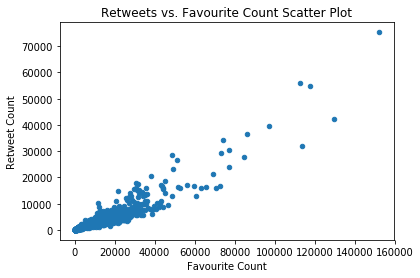

In [158]:
twitter_archive_master.plot(x='favorites',y='retweets',kind='scatter')
plt.xlabel('Favourite Count')
plt.ylabel('Retweet Count')
plt.title('Retweets vs. Favourite Count Scatter Plot')
plt.savefig('retweets_vs_favorites')

There appears to be a positive corelation between the number of times a tweet is favourited and the number of times it is retweeted.

### Is a particular dog stage more susceptible to higher ratings?

In [145]:
twitter_archive_master.groupby('dog_stage').overall_rating.mean()

dog_stage
doggo             1.180882
doggo, floofer    1.100000
doggo, pupper     1.100000
doggo, puppo      1.300000
floofer           1.200000
pupper            1.058199
puppo             1.207692
Name: overall_rating, dtype: float64

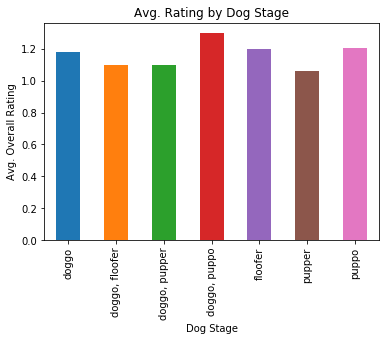

In [157]:
twitter_archive_master.groupby('dog_stage').overall_rating.mean().plot('bar')
plt.title ('Avg. Rating by Dog Stage')
plt.xlabel('Dog Stage')
plt.ylabel('Avg. Overall Rating')
plt.savefig('avg_rating_by_dog_stage')

Individually, puppo and floofer dog stages receive higher ratings. In cases where one tweet contains more than 1 dog, tweets with dogoo and puppo combinations receive the highest ratings. 

### What is the most assigned numerator rating?

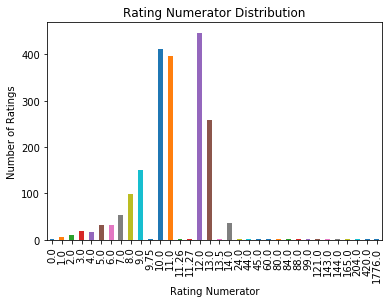

In [159]:
twitter_archive_master['rating_numerator'].value_counts().sort_index().plot('bar')
plt.title ('Rating Numerator Distribution')
plt.xlabel('Rating Numerator')
plt.ylabel('Number of Ratings')
plt.savefig('rating_numerator_distribution');

12 was the most often assigned numerator rating. There also appear to be quite a few outliers (.e.g 1776.0)